In [2]:
import pandas as pd
import numpy as np
import torch
import re
import tqdm
from matplotlib._path import (affine_transform, count_bboxes_overlapping_bbox,
     update_path_extents)

In [8]:
dataset=pd.read_csv('dataset.csv')
dataset.dropna(inplace = True)
dataset

,id,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [9]:
def clean_tweet(tweet):
    tweet = re.sub("#", "",tweet) # Removing '#' from hashtags
    tweet = re.sub("[^a-zA-Z#]", " ",tweet) # Removing punctuation and special characters
    tweet = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',"<URL>", tweet)
    tweet = re.sub('http','',tweet)
    tweet = re.sub(" +", " ", tweet)
    tweet = tweet.lower()
    return tweet
dataset["tweet"]=dataset["tweet"].apply(clean_tweet)

In [10]:
dataset.rename(columns={"tweet":"text","class":"label"},inplace=True)

In [11]:
dataset = dataset.reindex(columns = ['label','text'])

In [12]:
dataset

,label,text
0,2,rt mayasolovely as a woman you shouldn t comp...
1,1,rt mleew boy dats cold tyga dwn bad for cuffi...
2,1,rt urkindofbrand dawg rt sbaby life you ever ...
3,1,rt c g anderson viva based she look like a tr...
4,1,rt shenikaroberts the shit you hear about me ...
...,...,...
24778,1,you s a muthaf in lie lifeasking pearls corey ...
24779,2,you ve gone and broke the wrong heart baby and...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you lies


In [13]:
from sklearn.model_selection import train_test_split
train_full,test = train_test_split(dataset,train_size=0.8)

In [14]:
train,val = train_test_split(train_full,train_size=0.75)

In [15]:
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)
val.to_csv("valid.csv",index=False)

In [3]:
from torchtext.data import Field, TabularDataset, BucketIterator
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)

/home/akshay/anaconda3/envs/ire_major/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [4]:
fields = [('label',label_field),('text', text_field)]

In [5]:

train, valid, test = TabularDataset.splits(path="./", train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

/home/akshay/anaconda3/envs/ire_major/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
/home/akshay/anaconda3/envs/ire_major/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [6]:
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),device="cpu",
                            sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),device="cpu",
                            sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),device="cpu",
                            sort=True, sort_within_batch=True)

/home/akshay/anaconda3/envs/ire_major/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [7]:
text_field.build_vocab(train, min_freq=3)

In [9]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(2*dimension, 3)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_out = torch.softmax(text_fea,dim=1)

        return text_out

In [10]:
def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [36]:
from sklearn.preprocessing import label_binarize
device = "cpu"
def train_model(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = "./",
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels,(tweet, tweet_len)), _ in train_loader:
            tweet = tweet.to(device)
            tweet_len = tweet_len.to(device)            
            output = model(tweet, tweet_len)
            labels = labels.long()
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels,(tweet, tweet_len)), _ in valid_loader:
                        tweet = tweet.to(device)
                        tweet_len = tweet_len.to(device)
                        output = model(tweet, tweet_len)
                        labels = labels.long()
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [232/4650], Train Loss: 0.7153, Valid Loss: 0.6964
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/10], Step [464/4650], Train Loss: 0.6996, Valid Loss: 0.7003
Epoch [2/10], Step [696/4650], Train Loss: 0.6630, Valid Loss: 0.6795
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/10], Step [928/4650], Train Loss: 0.6827, Valid Loss: 0.6829
Epoch [3/10], Step [1160/4650], Train Loss: 0.6515, Valid Loss: 0.6797
Epoch [3/10], Step [1392/4650], Train Loss: 0.6713, Valid Loss: 0.6699
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/10], Step [1624/4650], Train Loss: 0.6470, Valid Loss: 0.6729
Epoch [4/10], Step [1856/4650], Train Loss: 0.6737, Valid Loss: 0.6715
Epoch [5/10], Step [2088/4650], Train Loss: 0.6449, Valid Loss: 0.6708
Epoch [5/10], Step [2320/4650], Train Loss: 0.6657, Valid Loss: 0.6647
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [6/10], Step [2552/4650], Train 

Model loaded from <== ./metrics.pt


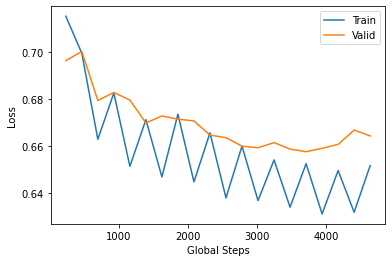

In [38]:
import matplotlib.pyplot as plt
train_loss_list, valid_loss_list, global_steps_list = load_metrics("." + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [41]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        correct = 0
        for (labels, (tweet, tweet_len)), _ in test_loader:           
            labels = labels.long()
            tweet = tweet.to(device)
            tweet_len = tweet_len.to(device)
            output = model(tweet, tweet_len)

            output = torch.argmax(output,dim=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
        for i,val in enumerate(y_pred):
            if y_true[i]==y_pred[i]:
                correct+=1
        print("Accuracy",correct/len(y_pred))
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint("." + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== ./model.pt
Accuracy 0.9047811176114585
